# Classification of Fashion-MNIST using a CNN with Keras

The Fashion-MNIST has 60,000 training samples and 10,000 test samples. Each sample is a 28x28 pixel grayscale (8-bit) image.

Classes:

|Label|Description|
|-----|-----------|
|0|T-shirt/top    |
|1|Trouser        |
|2|Pullover       |
|3|Dress          |
|4|Coat           |
|5|Sandal         |
|6|Shirt          |
|7|Sneaker        |
|8|Bag            |
|9|Ankle boot     |

In [62]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import inception_resnet_v2

import os
import scipy.ndimage
import numpy as np
import pandas as pd
import io
import PIL
import IPython
import collections
import hashlib
import matplotlib.pyplot as plt
import math
import datetime

## Load the data
Luckily, the Fashion-MNIST dataset is included in Keras, so this is a one-liner.

In [63]:
(x_train_indata, y_train_indata), (x_test_indata, y_test_indata) = fashion_mnist.load_data()

# for kaggle
# data_train = pd.read_csv('../input/fashion-mnist_train.csv')
# data_test = pd.read_csv('../input/fashion-mnist_test.csv')
# rows = 28
# cols = 28
# x_train_indata = np.ascontiguousarray(data_train.iloc[:, 1:])
# x_train_indata = x_train_indata.reshape(x_train_indata.shape[0], rows, cols)
# y_train_indata = np.ascontiguousarray(data_train.iloc[:, 0])
# x_test_indata = np.ascontiguousarray(data_test.iloc[:, 1:])
# x_test_indata = x_test_indata.reshape(x_test_indata.shape[0], rows, cols)
# y_test_indata = np.ascontiguousarray(data_test.iloc[:, 0])

## Data integrity

Check that the data looks reasonable by looking at a few random samples from the dataset.

(60000, 28, 28)


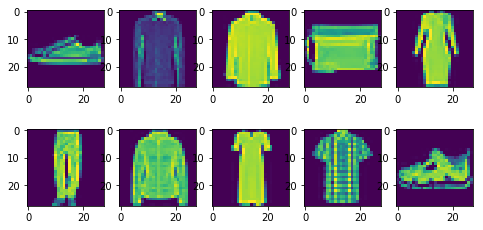

In [64]:
def render_random_images(data, num_samples):
    print(data.shape)
    cols = 5
    rows = math.ceil(num_samples/cols)
    idxs = np.random.choice(len(data), num_samples)
    f, ax = plt.subplots(rows, cols)
    f.set_size_inches(8, 4)
    for i, idx in enumerate(idxs):
        x = i//cols
        y = i%cols
        if rows > 1:
            ax[x, y].imshow(data[idx].reshape(data.shape[1], data.shape[2]))
        else:
            ax[i].imshow(data[idx].reshape(data.shape[1], data.shape[2]))
    plt.show()
    
render_random_images(x_train_indata, 10)

### Check for duplicates/overlaps
Does the training data and test data contain duplicates or do they overlap?

In [65]:
def overlap(a, b):
    ah = [hashlib.sha1(x).hexdigest() for x in a]
    bh = [hashlib.sha1(y).hexdigest() for y in b]
    overlaps = np.in1d(ah, bh)
    return collections.Counter(overlaps)[True]

def has_duplicates(a):
    ah = [hashlib.sha1(x).hexdigest() for x in a]
    _, counts = np.unique(ah, return_counts=True)    
    if len(collections.Counter(counts).keys()) > 1:
        return True
    return False
  
print("Overlaps between training and test sets:", overlap(x_train_indata, x_test_indata))
print("Duplicates in training set:", has_duplicates(x_train_indata))
print("Duplicates in test set:", has_duplicates(x_test_indata))

Overlaps between training and test sets: 0
Duplicates in training set: False
Duplicates in test set: False


### Check for class imbalance

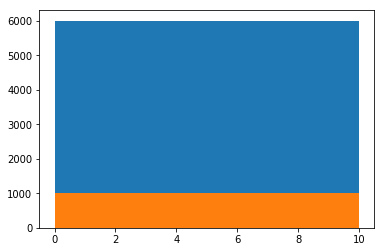

In [66]:
_ = plt.hist(y_train_indata, bins=range(0,11))
_ = plt.hist(y_test_indata, bins=range(0,11))

The classes are equally common. This was expected, but still good to check.

## Transform data / split

In [67]:
num_classes = 10
pixel_depth = 255.0

x_train, x_validation, y_train, y_validation = train_test_split(
    x_train_indata, 
    y_train_indata, 
    test_size=0.16666, 
    random_state=42)

# Add one dimension because the CNN layers expect n feature maps (color channels)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
y_train = to_categorical(y_train, num_classes=num_classes)
x_validation = x_validation.reshape(x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1)
y_validation = to_categorical(y_validation, num_classes=num_classes)

# zero-center and normalize pixels
# x_train = (x_train - (pixel_depth/2)) / pixel_depth
# x_validation = (x_validation - (pixel_depth/2)) / pixel_depth
x_train = inception_resnet_v2.preprocess_input(x_train)
x_validation = inception_resnet_v2.preprocess_input(x_validation)

Re-verify that the images look correct

(50000, 28, 28, 1)


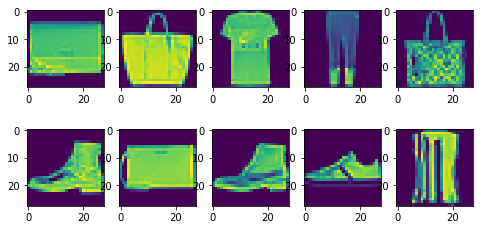

In [68]:
render_random_images(x_train, 10)

### Model definition and training

The model will start out simple with only one convolutional layer

In [69]:
def eval1d(model):
    score = model.evaluate(np.reshape(x_validation, (x_validation.shape[0], 784)), y_validation, verbose=0)
    for i, _ in enumerate(score):
        print(model.metrics_names[i], score[i])

In [70]:
def eval(model):
    score = model.evaluate(x_validation, y_validation, verbose=0)
    for i, _ in enumerate(score):
        print(model.metrics_names[i], score[i])

In [71]:
def model0():
    model = Sequential()
    model.add(Dense(num_classes, activation='softmax',input_shape=(784,)))
    model.custom_name = 'model0'
    return model

In [72]:
def model1():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(1,1), input_shape=(28,28,1)))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.custom_name = 'model1'
    return model

In [73]:
def model2():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
    model.add(Conv2D(16, kernel_size=(2,2)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
    model.add(Conv2D(16, kernel_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.custom_name = 'model2'
    return model

In [27]:
def run(model):
    epochs = 30
    batch_size = 32
#     sgd = tf.keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    adam = tf.keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    run_name = datetime.datetime.now().strftime("_run_%Y-%m-%dT%H_%M_%S")
    tb_cb = tf.keras.callbacks.TensorBoard(log_dir="./graph/" + model.custom_name + run_name,
                                           histogram_freq=1,
                                           write_graph=False,
                                           write_images=True,
                                           write_grads=True)
    es_cb = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                  min_delta=0,
                                  patience=2,
                                  verbose=0, mode='auto')
    
    if model.custom_name == 'model0':
        model.fit(np.reshape(x_train, (x_train.shape[0], 784)),
                  y_train,
                  validation_data=(np.reshape(x_validation, (x_validation.shape[0], 784)), y_validation),
                  epochs=epochs,
                  batch_size=batch_size,
                  callbacks=[es_cb, tb_cb])
        eval1d(model)
    else:
        model.fit(x_train, 
                  y_train,
                  validation_data=(x_validation, y_validation),
                  epochs=epochs,
                  batch_size=batch_size,
                  callbacks=[es_cb, tb_cb])
        eval(model)

tf.keras.backend.clear_session()
run(model0())
tf.keras.backend.clear_session()
run(model1())
tf.keras.backend.clear_session()
run(model2())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 6s 115us/step - loss: 0.5581 - acc: 0.8035 - val_loss: 0.4796 - val_acc: 0.8346
Epoch 2/30
50000/50000 [==============================] - 5s 108us/step - loss: 0.4602 - acc: 0.8393 - val_loss: 0.4670 - val_acc: 0.8357
Epoch 3/30
50000/50000 [==============================] - 6s 111us/step - loss: 0.4394 - acc: 0.8464 - val_loss: 0.4630 - val_acc: 0.8403
Epoch 4/30
50000/50000 [==============================] - 5s 109us/step - loss: 0.4322 - acc: 0.8492 - val_loss: 0.4596 - val_acc: 0.8354
Epoch 5/30
50000/50000 [==============================] - 5s 109us

In [74]:
# This requires 15-20GB RAM
def prepare_img_data_for_inception():
    fname1 = 'x_train_inc.npy'
    fname2 = 'x_validation_inc.npy'
    if not (os.path.isfile(fname1) and os.path.isfile(fname2)):
        print('generating...')
        x_train_zoom = scipy.ndimage.zoom(x_train, (1,3,3,1), order=0)
        x_validation_zoom = scipy.ndimage.zoom(x_validation, (1,3,3,1), order=0)
        x_train_inc = np.repeat(x_train_zoom, 3, axis=3)
        x_validation_inc = np.repeat(x_validation_zoom, 3, axis=3)
        np.save(fname1, x_train_inc)
        np.save(fname2, x_validation_inc)
        print('done generating')
    else:
        print('loading...')
        x_train_inc = np.load(fname1)
        x_validation_inc = np.load(fname2)
        print('done loading')
    return x_train_inc, x_validation_inc

In [75]:
def preprocess_inception():
    print("creating inception model (this takes a while)...")
    inception = inception_resnet_v2.InceptionResNetV2(
                                                    include_top=False,
                                                    weights='imagenet',
                                                    input_tensor=None,
                                                    input_shape=(84,84,3),
                                                    pooling=None)
    #features = np.empty(x_train_inc.shape[0], )
    print("extracting features from training images...")
    features_train = inception.predict(x_train_inc, verbose=1)
    print("extracting features from validation images...")
    features_validation = inception.predict(x_validation_inc, verbose=1)
    print("done extracting")
    # reshape, because predict() returns an array with shape ("num samples", 1, 1, "output layer size")
    features_train = np.reshape(features_train, (features_train.shape[0], features_train.shape[3]))
    features_validation = np.reshape(features_validation, (features_validation.shape[0], features_validation.shape[3]))
    return features_train, features_validation

feature_file_name1 = 'inception_features_train.npy'
feature_file_name2 = 'inception_features_validation.npy'
if not (os.path.isfile(feature_file_name1) and os.path.isfile(feature_file_name2)):
    x_train_inc, x_validation_inc = prepare_img_data_for_inception()
    features_train, features_validation = preprocess_inception()
    np.save(feature_file_name1, features_train)
    np.save(feature_file_name2, features_validation)
else:
    features_train = np.load(feature_file_name1)
    features_validation = np.load(feature_file_name2)

In [26]:
def model3():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(features_train.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    model.custom_name = "model3"
    return model

def run_model3(model):
    epochs = 30
    batch_size = 32
#    sgd = tf.keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    adam = tf.keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    run_name = datetime.datetime.now().strftime("_run_%Y-%m-%dT%H_%M_%S")
    tb_cb = tf.keras.callbacks.TensorBoard(log_dir="./graph/" + model.custom_name + run_name,
                                           histogram_freq=0,
                                           write_graph=False,
                                           write_images=False,
                                           write_grads=False)
    es_cb = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                  min_delta=0,
                                  patience=2,
                                  verbose=0, mode='auto')
    
    model.fit(features_train,
              y_train,
              validation_data=(features_validation, y_validation),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[es_cb, tb_cb])

    # evaluate model
    score = model.evaluate(features_validation, y_validation, verbose=0)
    for i, _ in enumerate(score):
        print(model.metrics_names[i], score[i])
    
run_model3(model3())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 128)               196736    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1290      
Total params: 214,538
Trainable params: 214,538
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 9s 176us/step - loss: 0.9347 - acc: 0.6773 - val_loss: 0.5805 - val_acc: 0.7947
Epoch 2/30
50000/50000 [==============================] - 6s 116us/step - loss: 